In [1]:
import pandas as pd
import numpy as np
from trading_rule import *
import matplotlib.pyplot as plt

In [2]:
data_path = f'Data/Forex/EURUSD.csv'
data = pd.read_csv(data_path)

In [3]:
data.set_index('Datetime',inplace=True)
data.sort_index(ascending=True,inplace=True)

In [4]:
def store_rule(rule_obj:TradingRule,signals,bisignals,pnls):
  signals.append(rule_obj.signal)
  bisignals.append(rule_obj.bisignal)
  pnls.append(rule_obj.pnl)

In [54]:
from itertools import product
signals = []
bisignals = []
pnls = []

lookbacks = [6*2**i for i in range(8)]

for lookback in lookbacks:
  for thr in [0.85,0.95,0.99]:
    store_rule(ChannelBreakout(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(SkewPremium(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(KurtReversal(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
  for thr in [3,5,7]:
    store_rule(LongFilter(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(ShortFilter(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
  
  for thr in [1,2,3]:
    store_rule(EWMAC(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(BollingerBand(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(NDayMomentum(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
  

In [55]:
signals_df = pd.concat(signals,axis=1).dropna()
bisignals_df = pd.concat(bisignals,axis=1).dropna()
pnls_df = pd.concat(pnls,axis=1).dropna()

In [75]:
def sr(pnl):
  pnl = pnl.fillna(0)
  mu = pnl.mean()
  sig = pnl.std()
  n_per_year = 24*252
  sr = mu/sig*n_per_year**0.5
  return sr

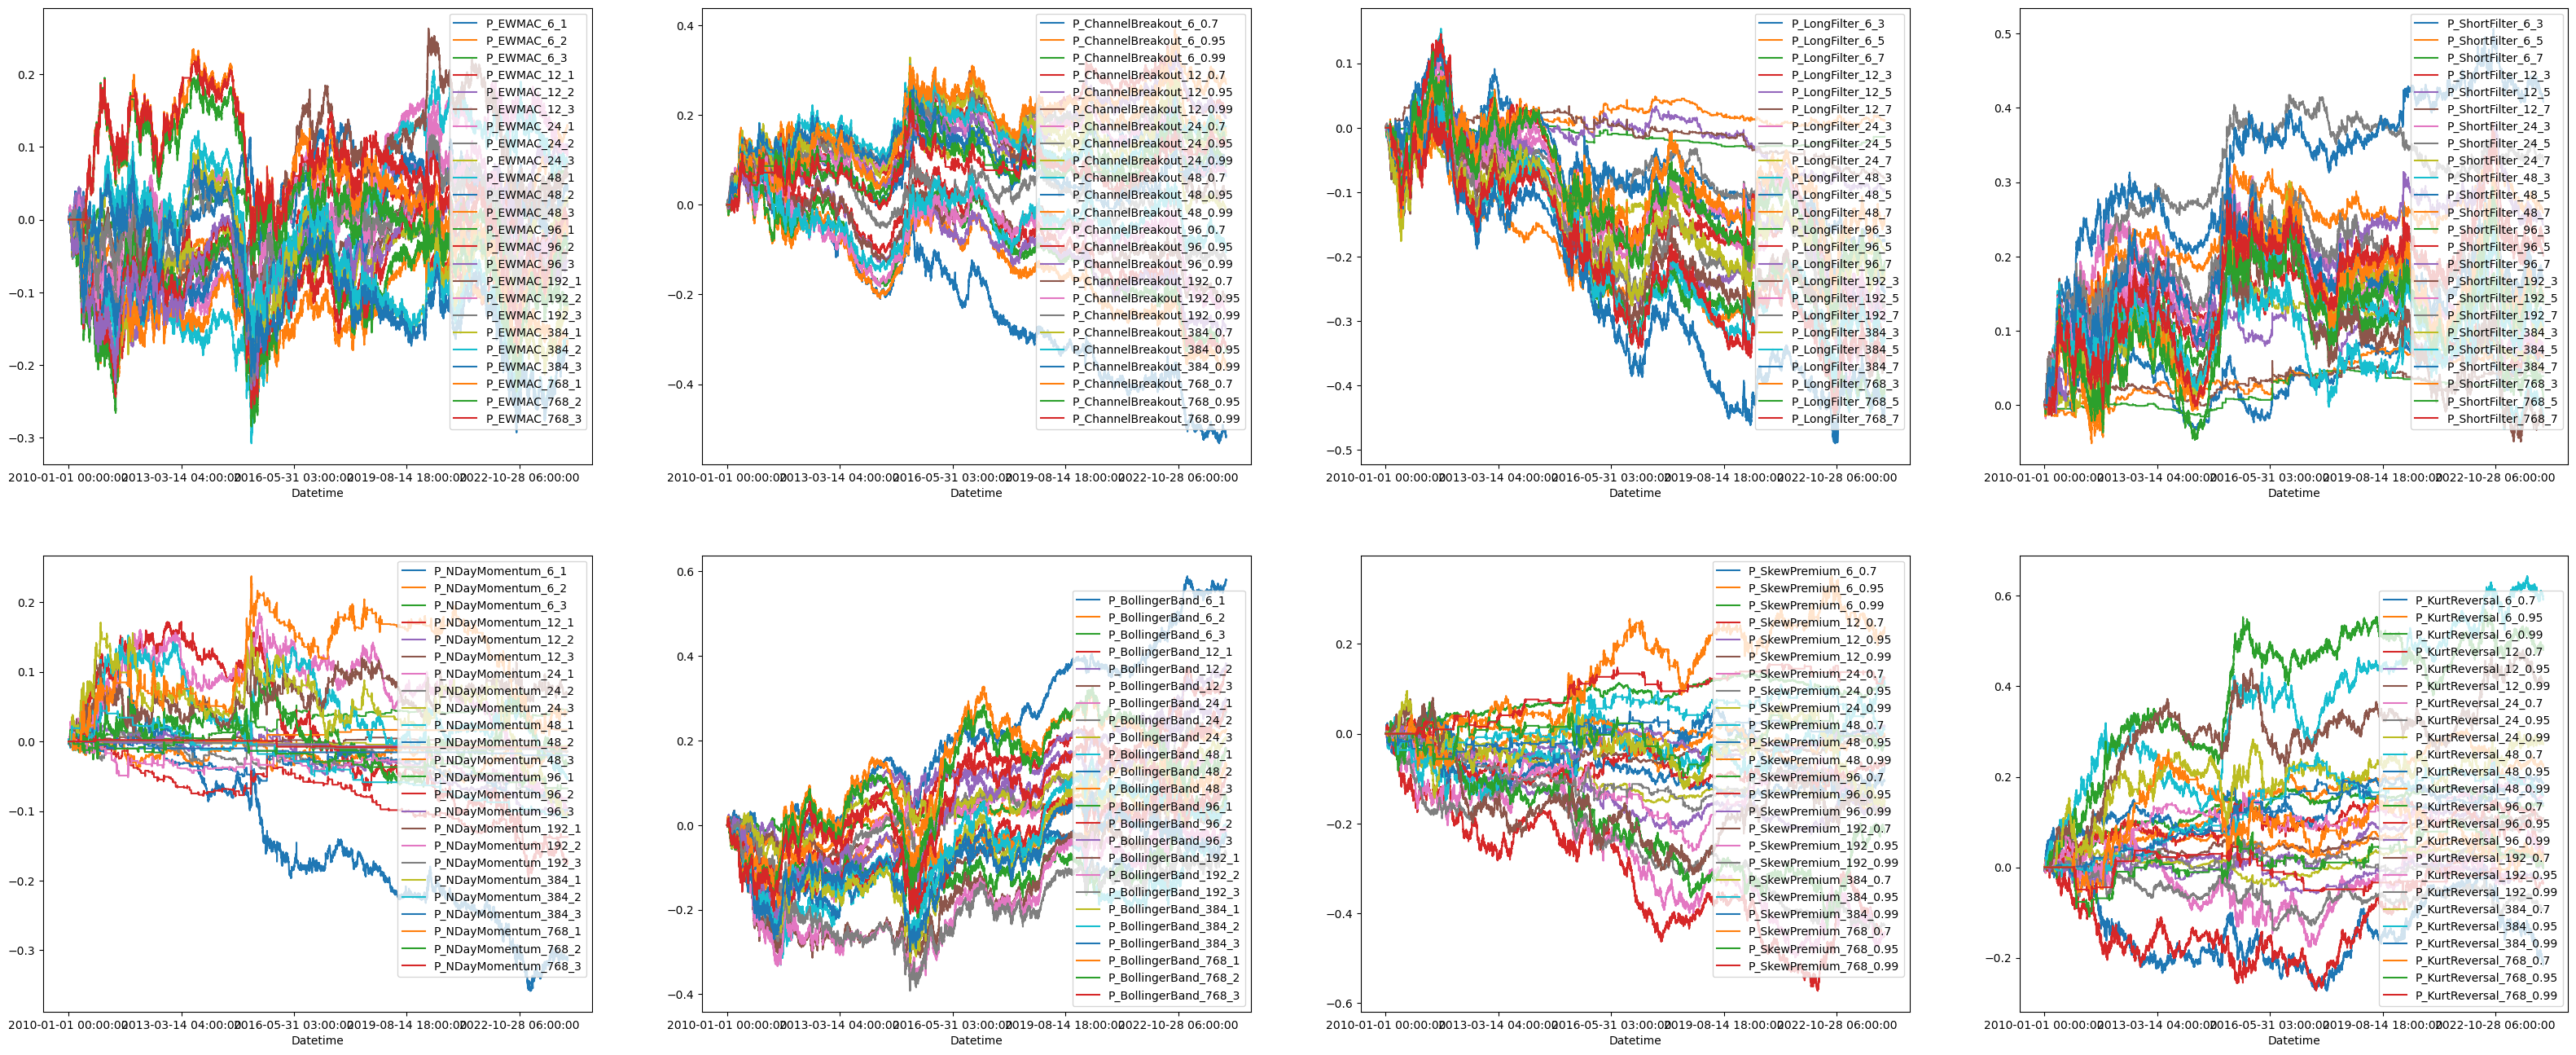

In [8]:
strats = ['EWMAC','ChannelBreakout','LongFilter','ShortFilter','NDayMomentum','BollingerBand','SkewPremium','KurtReversal']

fig,axes = plt.subplots(2,4,figsize=(40,16))
for i,strat in enumerate(strats):
  cols = pnls_df.columns[pnls_df.columns.str.match(f'P_{strat}_*')]
  ax = axes[i//4,i%4]
  pnls_df.loc[:,cols].cumsum().plot(ax=ax)

# KMean

In [27]:
from sklearn.cluster import KMeans

In [84]:
train_size = 480*12
step = 480*12

all_rf_pred = dict()
all_rf_prob = dict()

pnls_list = []

dataset = pnls_df
for start in range(train_size, len(dataset), step):
    # rolling train set
    train_set = dataset.iloc[start - train_size : start - lookback]
    # expanding train set
    # train_set = dataset.iloc[ : start - lookback]
    test_set = dataset.iloc[start : start + step]

    train_x = train_set.corr()

    print(test_set.index[0])

    kmeans = KMeans(n_clusters=24, random_state=0, n_init="auto")
    kmeans.fit(pnls_df.corr())
    groups = kmeans.labels_

    port = {i: [] for i in range(24)}
    for i,group in enumerate(groups):
      port[group].append(pnls_df.columns[i])
    port_pnl = pd.DataFrame()
    for i,s_list in (port.items()):
      port_pnl[i] = (train_set.loc[:,s_list].mean(axis=1))
    port_sr = port_pnl.apply(sr)
    long_port = port_sr[port_sr >= port_sr.quantile(0.5)].index
    short_port = port_sr[port_sr <= port_sr.quantile(0.5)].index
    
    long_strat = []
    for p in long_port:
      long_strat += port[p]
    long_pnl = test_set.loc[:,long_strat].mean(axis=1)
    short_strat = []
    for p in short_port:
      short_strat += port[p]
    short_pnl = -test_set.loc[:,short_strat].mean(axis=1)
    pnls_list.append(long_pnl + short_pnl)
pnl = pd.concat(pnls_list)

2010-12-03 00:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2011-11-03 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2012-10-04 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2013-09-06 20:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2014-08-12 08:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2015-07-15 21:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2016-06-17 11:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2017-05-19 12:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2018-04-24 03:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2019-03-27 16:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2020-02-28 09:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2021-02-01 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2022-01-03 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2022-12-05 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2023-11-06 23:00:00


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Axes: xlabel='Datetime'>

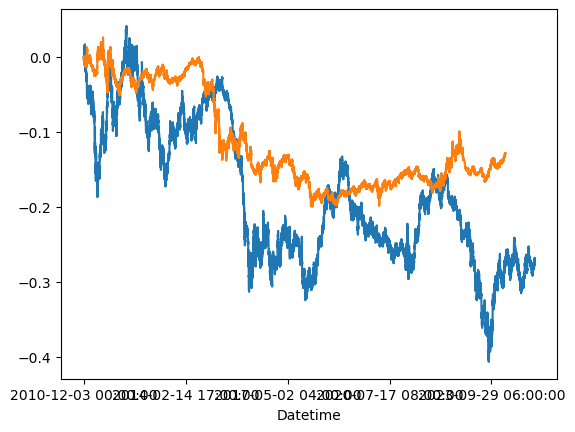

In [85]:
np.log(data.Close).diff().cumsum().plot()
pnl.cumsum().plot()

In [87]:
kmeans = KMeans(n_clusters=24, random_state=0, n_init="auto")
kmeans.fit(pnls_df.corr())
groups = kmeans.labels_

port = {i: list() for i in range(24)}
for i,group in enumerate(groups):
  port[group].append(pnls_df.columns[i])

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


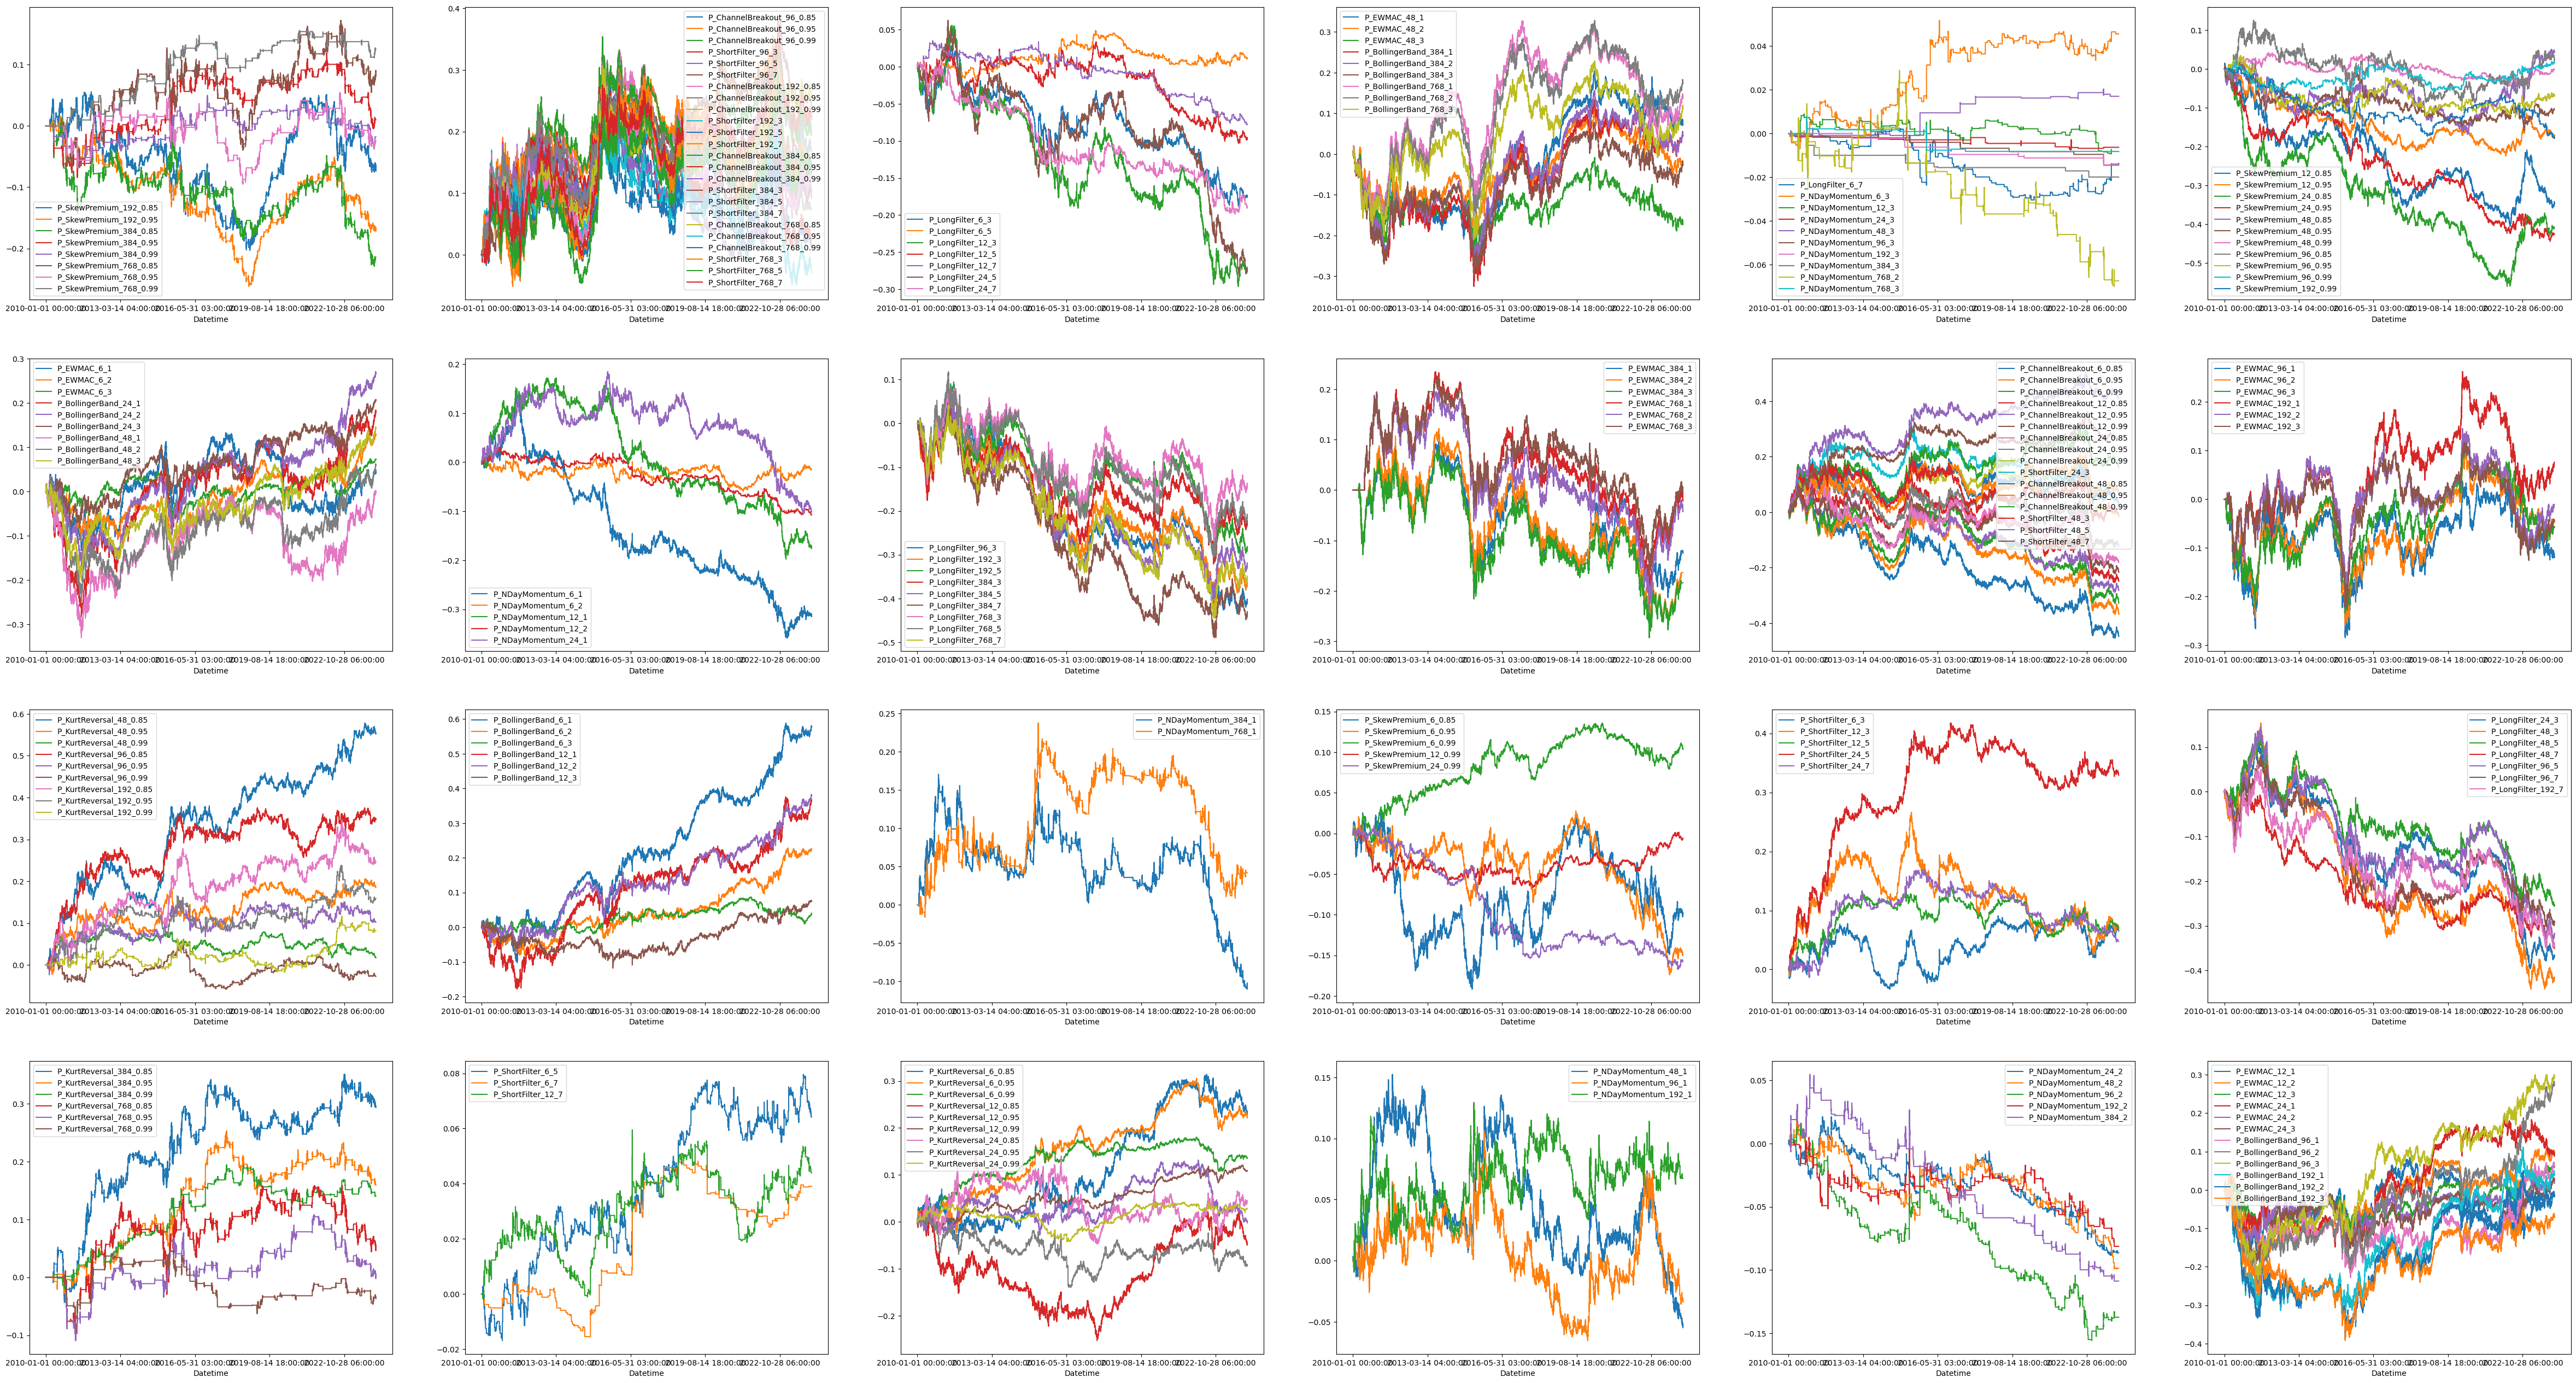

In [89]:
fig,axes = plt.subplots(4,6,figsize=(60,32))
for i,s_list in (port.items()):
  ax = axes[i//6,i%6]
  pnls_df.loc[:,s_list].cumsum().plot(ax=ax)

In [47]:
pnls_df.loc[:,s_list].mean(axis=1)

Datetime
2010-01-01 00:00:00    0.0
2010-01-01 01:00:00    0.0
2010-01-01 02:00:00    0.0
2010-01-01 03:00:00    0.0
2010-01-01 04:00:00    0.0
                      ... 
2024-03-08 19:00:00    0.0
2024-03-08 20:00:00    0.0
2024-03-08 21:00:00    0.0
2024-03-10 21:00:00    0.0
2024-03-10 22:00:00    0.0
Length: 88498, dtype: float64

In [53]:
for i,s_list in (port.items()):
  port_sr = pnls_df.loc[:,s_list].apply(sr)
  print(i,':',port_sr)

0 : P_SkewPremium_384_0.7    -0.150364
P_SkewPremium_384_0.95    0.017724
P_SkewPremium_384_0.99   -0.048779
P_SkewPremium_768_0.7     0.243180
P_SkewPremium_768_0.95   -0.043116
P_SkewPremium_768_0.99    0.349240
dtype: float64
1 : P_ChannelBreakout_48_0.95     0.068940
P_ChannelBreakout_48_0.99     0.178448
P_ShortFilter_48_5            0.509837
P_ShortFilter_48_7            0.399808
P_ChannelBreakout_96_0.95     0.221298
P_ChannelBreakout_96_0.99     0.213809
P_ShortFilter_96_5            0.211904
P_ShortFilter_96_7            0.290755
P_ChannelBreakout_192_0.95    0.077237
P_ChannelBreakout_192_0.99    0.136700
P_ShortFilter_192_7           0.144195
dtype: float64
2 : P_LongFilter_6_3    -0.383344
P_LongFilter_12_3   -0.433027
P_LongFilter_12_5   -0.253630
P_LongFilter_24_3   -0.448160
P_LongFilter_24_5   -0.465303
P_LongFilter_24_7   -0.481397
P_LongFilter_48_5   -0.321381
P_LongFilter_48_7   -0.549994
dtype: float64
3 : P_EWMAC_6_1             0.041197
P_EWMAC_6_2             0.1

# AggClust

In [11]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [18]:
def plot_dendrogram(model,ax):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,ax=ax)

In [19]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(pnls_df.corr())

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

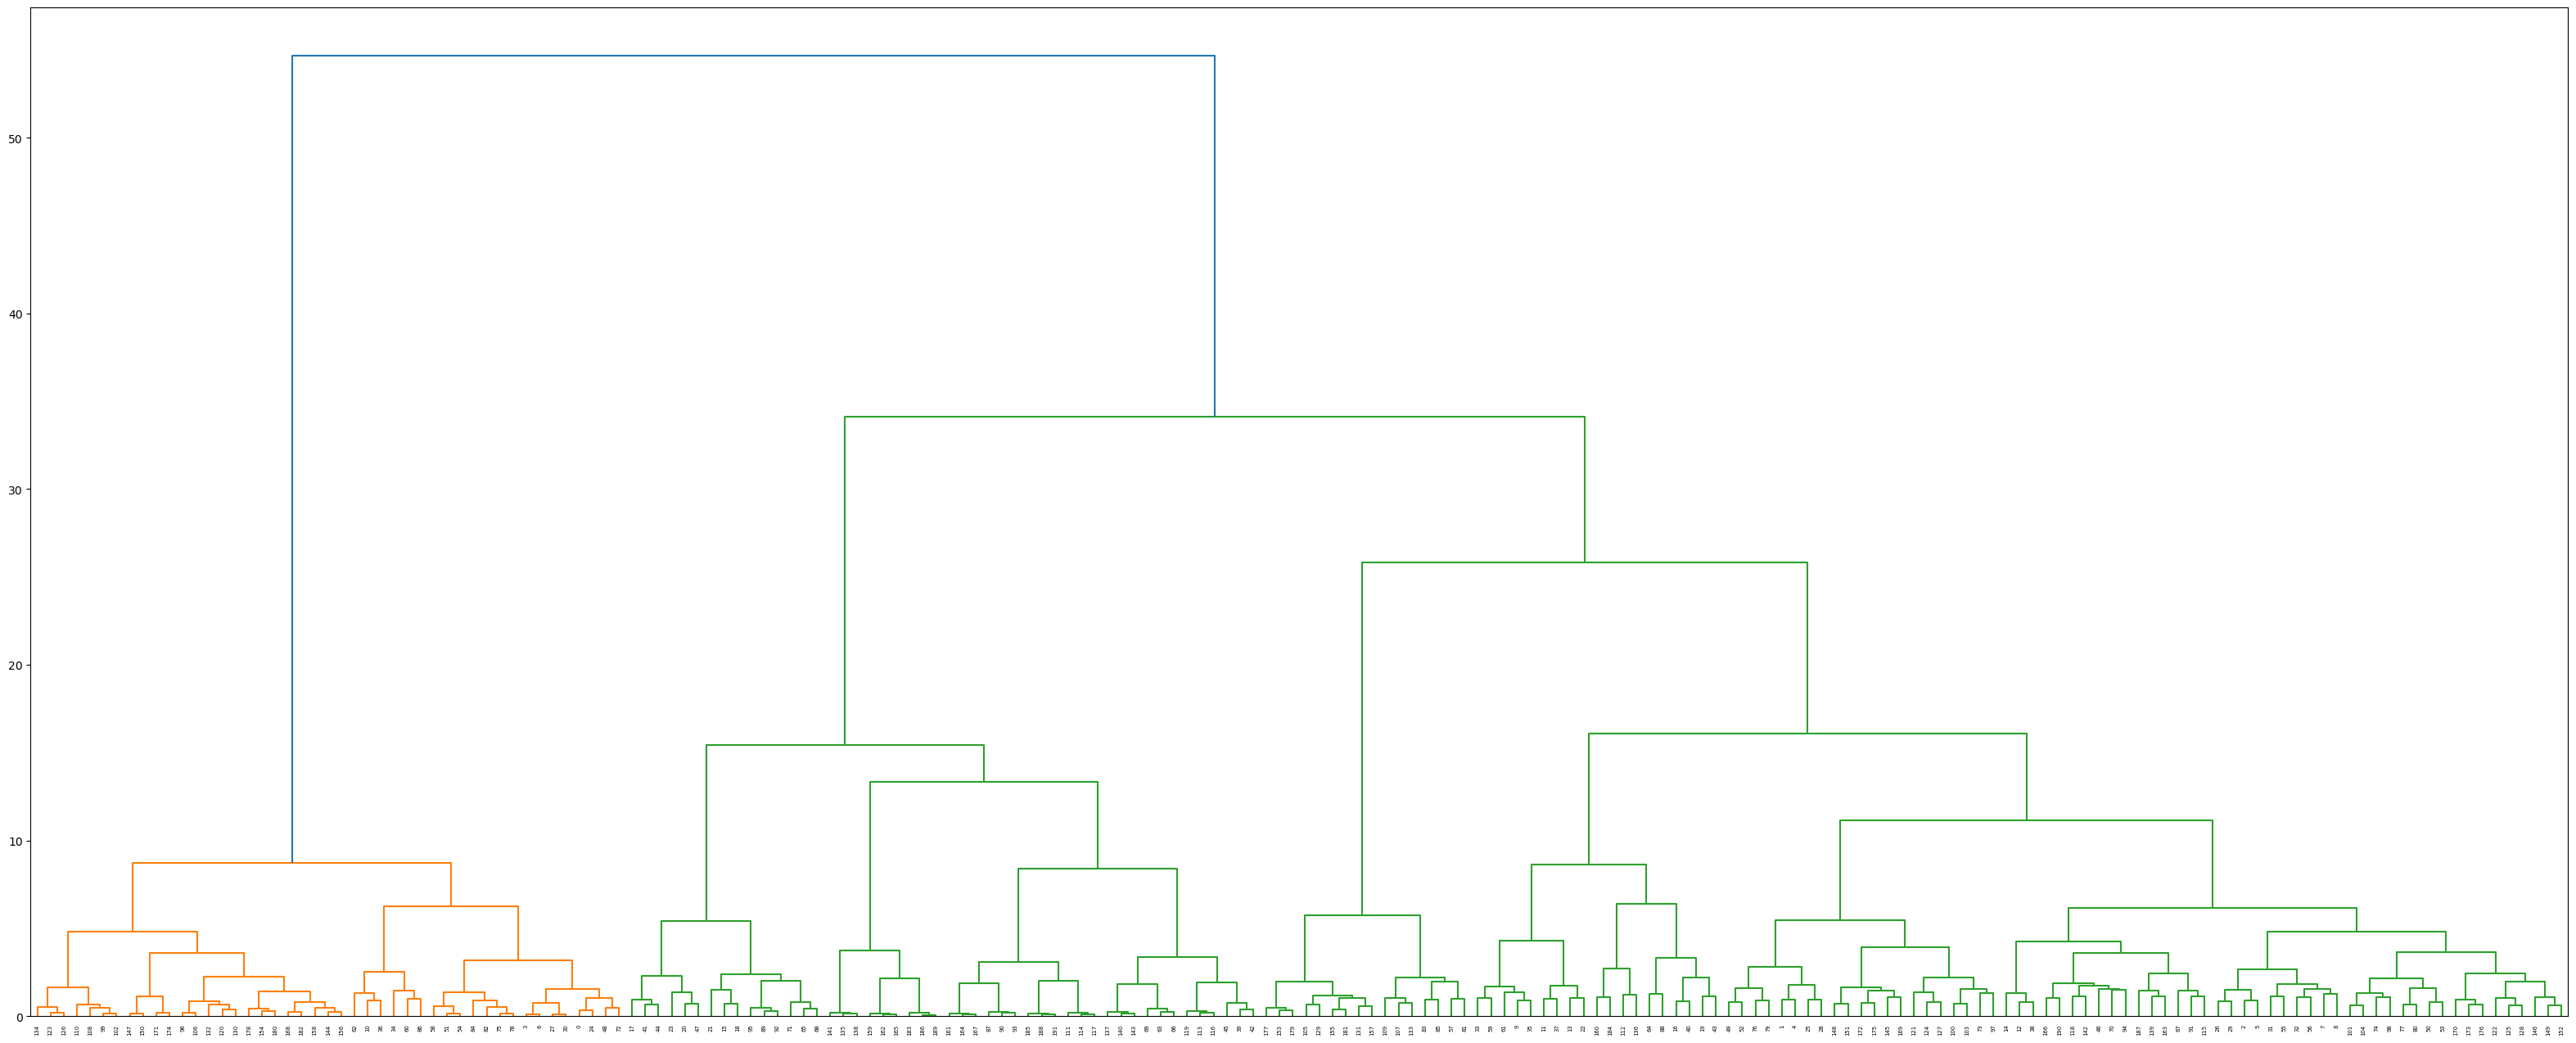

In [26]:
fig,ax = plt.subplots(figsize=(40,16))
plot_dendrogram(model,ax=ax)

# HRP

In [8]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [9]:
hrp = HRPOpt(pnls_df)

In [10]:
hrp.optimize()

OrderedDict([('P_BollingerBand_12_1', 4.965419272507785e-06),
             ('P_BollingerBand_12_2', 1.141890294472937e-05),
             ('P_BollingerBand_12_3', 5.918875734583587e-05),
             ('P_BollingerBand_192_1', 2.8149911085109723e-06),
             ('P_BollingerBand_192_2', 6.482406671313592e-06),
             ('P_BollingerBand_192_3', 3.335117948611472e-06),
             ('P_BollingerBand_24_1', 5.815536425951956e-06),
             ('P_BollingerBand_24_2', 6.304609392538037e-06),
             ('P_BollingerBand_24_3', 7.631948515761401e-06),
             ('P_BollingerBand_384_1', 4.065718471373458e-06),
             ('P_BollingerBand_384_2', 4.3025320429956075e-06),
             ('P_BollingerBand_384_3', 1.6997115776264173e-05),
             ('P_BollingerBand_48_1', 2.9577884986447482e-06),
             ('P_BollingerBand_48_2', 7.400602059360498e-06),
             ('P_BollingerBand_48_3', 4.498406540079781e-06),
             ('P_BollingerBand_6_1', 8.793287355404795e-06),

In [12]:
hrp.portfolio_performance(risk_free_rate=0,frequency=252*24)

(-0.0001824357287829505, 0.0007505623064044045, -0.24306540206757163)